# Predicting Flight Delays Two Hours in Advance 

### Alex Carite, Muhammad Jawaid, Peter Morgan, and Thomas Welsh

### Modeling Notebook

### Step 1a: Import Libraries

In [ ]:
from pyspark.sql.functions import col, when, substring
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, IntegerType, BinaryType, UserDefinedType, FloatType, StructType, StructField


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import datetime as dt
import itertools
import re

from pyspark.ml.linalg import DenseVector, SparseVector, Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, Imputer, StringIndexer, OneHotEncoder, VectorSlicer

from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from sparkdl.xgboost import XgboostClassifier

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

!pip install -U airportsdata
import airportsdata
from graphframes import *
print("Welcome to the W261 final project - Team 18 in the house!")
from pyspark.sql.functions import monotonically_increasing_id,row_number
from pyspark.sql.window import Window

spark.sparkContext.addPyFile("dbfs:/custom_cv.py")
from custom_cv import CustomCrossValidator

Requirement already satisfied: airportsdata in /databricks/python3/lib/python3.8/site-packages (20220731)
 WARNING: You are using pip version 21.0.1; however, version 22.2.2 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command. 
Welcome to the W261 final project - Team 18 in the house!

In [ ]:

# Inspect the Mount's Final Project folder 
# Please IGNORE dbutils.fs.cp("/mnt/mids-w261/datasets_final_project/stations_data/", "/mnt/mids-w261/datasets_final_project_2022/stations_data/", recurse=True)
data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"

In [ ]:

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [ ]:
#helper functions to save to the blob
def save_to_blob(obj, path_str):
  """
  Saves the obj to the blob at the provided file name 
  """

  path = f"{blob_url}/{path_str}"
  
  try:
    obj.write.format("delta").mode("overwrite").save(path)
  except:
    print('This File already exists')

def load_blob_obj(path_str):
  """
  Loads object to the notebook that is saved into the blob 
  """
  path = f"{blob_url}/{path_str}"
  
  try:
    return spark.read.format("delta").load(path)
  except:
    print(f"no file name {path_str} exists")

### Step 1b: Import Data

In [ ]:
# # Load Full (Provided) DataFrames
df_airlines = spark.read.parquet(f"{data_BASE_DIR}parquet_airlines_data/")
df_weather = spark.read.parquet(f"{data_BASE_DIR}parquet_weather_data/")
df_stations = spark.read.parquet(f"{data_BASE_DIR}stations_data/*")

In [ ]:
# # Load IATA Dataframe (NOT PROVIDED) for the translating 4-character Airport Call data to 3-character IATA airport codes (very small dataset) and adding timezone information to airports
airports = airportsdata.load()
iata = pd.DataFrame.from_dict(airports).transpose()
iata.drop(['lat','lon'], axis = 1, inplace=True)
iata = iata[iata['country'] == "US"]
iata = iata[iata['iata'] != ""]
iata.drop(['city','subd','country','elevation'], axis = 1, inplace = True)
iata.rename({'icao':'neighbor_call'}, axis = 1, inplace = True)
df_iata = spark.createDataFrame(iata)
df_iata.distinct()
print("IATA DATAFRAME:")
df_iata.display()

### Step 2: Exploratory Data Analysis

Note: EDA was primarily conducted in <a href="$./w261_Final_Project_Team_18_Phase_1_and_2_Final">this separate notebook</a>.  Key parts of that EDA (but not all of it) are included below as commented code for reference.

In [ ]:
# # Run on Full airline Data
dbutils.data.summarize(df_airlines)

Per the table above, the raw airline data has 74.2M records. There are 18 numerical features in the airline data that have over 80% null values. These features are dropped. We can see from our target variable "DEP_DEL15" that the mean is 0.18. That means that 18% of our flights are delayed and the rest of the flights are not delayed. Also interesting is the "DEP_DELAY" feature which has a mean of 9.35. This says that the mean delay time is just over 9 minutes for all flights in this dataset. Moving on to the categorical variables, an interesting tidbit is that there are 379 unique "ORIGIN" airports but only 377 unique "DEST" airports. This means that there are 2 airports that are only used for departing flights but no arriving flights. Similar to the numerical features, there are several features that have a lot of Null values. There are 36 columns that have greater than 90% nulls from the categorical variables in the airline data and these features will be dropped

In [ ]:
# # Run on Full Weather Data
dbutils.data.summarize(df_weather)

Per the table above, we can see the raw weather dataset has 899 million rows. Most of the features in this dataset have almost all Null values which we can see when examining the "missing" column above. At face value it appears that this data is mostly unusable, but we are able to impute many of the values by getting data from the FM-15 report. This method will be described further in the data processing pipeline section as we have to extract METAR data to get anything useful from this data due to the large number of Nulls.

In [ ]:
# # Run on Full Stations Data

dbutils.data.summarize(df_stations)

The stations data has 5 million rows with zero null values in the entire dataset. This data compares two stations to each other and shows the distance between them. One interesting aspect of this dataset is the distribution of the "distance_to_neighbor" field. The distribution is right skewed and this means that most of the stations are within a reasonable distance of each other and there are a few stations that are very far away. One can also see this by examining the mean / median field because the mean is much higher than the median.

### Step 3: Data Pre-Processing and Joining

In [ ]:
# # drop duplicate rows for airlines, select columns
df_airlines = df_airlines.dropDuplicates(['ORIGIN', 'DEST', 'DEP_TIME', 'CRS_DEP_TIME', 'TAIL_NUM'])\
                          .select('ORIGIN', 'DEST', 
                                 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY',
                                 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP',
                                 'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_TIME',
                                 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15',
                                 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED',
                                 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'TAIL_NUM',
                                 'FLIGHTS', 'DISTANCE', 'CARRIER_DELAY',
                                 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
                                 'LATE_AIRCRAFT_DELAY', 'FL_DATE')

# select just those stations with distance to themselves of 0--these are the airports
# choose columns, and keep distinct ones
df_stations = df_stations.filter(col("distance_to_neighbor") == 0)\
                .select(['neighbor_call', 'neighbor_name', 'neighbor_state', 'lat', 'lon'])\
                .distinct()

# Gather information about dataframes just prior to join for later comparison
df_airlines_priortojoinwithstations_length = df_airlines.count()
df_stations_priortojoinwithairlines_length = df_stations.count()
df_airlines_priortojoinwithstations_width = len(df_airlines.columns)
df_stations_priortojoinwithairlines_width = len(df_stations.columns)

# Select weather columns for use
# Select weather data from only North America (LATITUDE in stations went from 18.25 (PR) to 71.333 (AK), and LONGITUDE went from -176.65 (AK) to -66.098 (PR)
# Note: EARECKSON AIR STATION AIRPORT seems to have a bad lon point of 174.1 instead of -174.1), but not pulled through to df_main
# Then add timestamp column that will match format with df_airlines later on
# Drop the duplicate weather reports--by using orderBy descending before dropDuplicate, we keep the weather report that is closest
# timestamp_utc of the weather that is closest to 2 hours prior to scheduled departure

df_weather = df_weather.select('STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION',
                               'REPORT_TYPE', 'SOURCE', 'HourlyAltimeterSetting',
                               'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 
                               'HourlyPrecipitation', 'HourlyPresentWeatherType', 'HourlyRelativeHumidity',
                               'HourlySkyConditions', 'HourlyStationPressure', 'HourlyVisibility', 
                               'HourlyWetBulbTemperature','HourlyWindDirection','HourlyWindSpeed','REM','YEAR')\
                      .filter((df_weather['LATITUDE'] > 15) & (df_weather['LATITUDE'] < 75) & (df_weather['LONGITUDE'] < (-70)) & (df_weather['LONGITUDE'] > (-178)) & (df_weather['REPORT_TYPE'] == 'FM-15'))\
                      .withColumn('timestamp_date',to_timestamp(col('DATE'), "yyyy-MM-dd'T'HH:mm:ss"))

df_weather = df_weather.withColumn("timestamp_utc", F.date_trunc("hour", df_weather.timestamp_date))\
                      .orderBy(col('DATE').desc())


In [ ]:
# # Join df_iata to df_stations to get 3-code airport ID and timezone -- you will need this for joining the 3 main dataframes
df_stations = df_stations.join(df_iata, df_stations['neighbor_call'] == df_iata['neighbor_call'], "left").drop(df_stations['neighbor_call'])
df_stations = df_stations.select(['iata', 'name', 'neighbor_call', 'neighbor_name', 'neighbor_state', 'lat', 'lon', 'tz'])
# print("STATIONS DATAFRAME:")
# df_stations.display()

# Join df_stations to df_airlines on 3-code airport ID
df_airlines = df_airlines.join(df_stations, df_airlines['ORIGIN'] == df_stations['iata'], "left").drop(df_airlines['ORIGIN'])
# print("AIRLINES DATAFRAME:")
# df_airlines.display()

# Gather post-join statistics
df_airlines_afterjoinwithstations_length = df_airlines.count()
df_airlines_aftertojoinwithstations_width = len(df_airlines.columns)

# Helper functions for extracting airport_call data from METAR field in df_weather further below
def clean_metar(obs):
  return str(re.sub('^\S* ', '', str(obs)))

def strip_airport(obs):
  airport_search =  re.search(' (K\S+)', str(obs), re.IGNORECASE)
  if airport_search:
    return airport_search.group(1)
  else:
    return str(re.sub(' .*$', '', str(obs)))

newREM = udf(lambda x: clean_metar(x), StringType())
airport_name = udf(lambda x: strip_airport(x), StringType())

# METAR and airport_call columns added to the weather database
df_weather = df_weather.withColumn("METAR", newREM(col('REM')))\
                       .withColumn('airport_call', airport_name(col('METAR')))

# Remove duplicates - latest eligible timestamp kept (because df_weather ordered by 'DATE' above)
df_weather = df_weather.dropDuplicates(['timestamp_utc', 'airport_call'])

# print("WEATHER DATAFRAME:")
# df_weather.display()

In [ ]:
# Timestamp processing
## Part 1 (Convert to Date Time)
# Cast Computer Reservation System Departure Time to string
df_airlines=df_airlines.withColumn('timestamp',df_airlines.CRS_DEP_TIME.cast(StringType()))

# Add 1 leading zero to times with length 3 to make timestamps consistent (example: 949 gets updated to 0949, thereby giving each timestamp a length of 4)
df_airlines = df_airlines.withColumn('timestamp', F.lpad(F.col('timestamp'), 4, '0'))

# Add 2 trailing zeroes to give timestamp seconds for comparison to weather data
df_airlines = df_airlines.withColumn('timestamp', F.rpad(F.col('timestamp'), 6, '0'))

# Concatenate date and time
df_airlines=df_airlines.withColumn('timestamp',concat(df_airlines.FL_DATE,lit('T'), df_airlines.timestamp))

# Convert date and time string to timestamp 
df_airlines = df_airlines.withColumn('timestamp_string',to_timestamp(col('timestamp'), "yyyy-MM-dd'T'HHmmss"))
# df_airlines.select('timestamp_string').show()

In [ ]:
## Part 2(Update Date Time)

# Round hour down (to join to weather data because it is rounded)
df_airlines=df_airlines.withColumn("rounded_timestamp", F.date_trunc("hour", df_airlines.timestamp_string))

# Substract 2 hours
df_airlines = df_airlines.withColumn("minus_2hours_timestamp",col("rounded_timestamp") - expr("INTERVAL 2 HOURS"))

df_airlines.createOrReplaceTempView("airlines") # Create a temporary view
df_airlines = spark.sql("SELECT *, to_utc_timestamp( minus_2hours_timestamp, tz) as FINAL_DEP_TIME_tz FROM airlines")

df_airlines.createOrReplaceTempView("airlines") # Create a temporary view
spark.sql("SELECT FL_DATE,CRS_DEP_TIME,timestamp, timestamp_string,rounded_timestamp,minus_2hours_timestamp, FINAL_DEP_TIME_tz, tz FROM airlines WHERE CRS_DEP_TIME IS NOT NULL").show()

In [ ]:
# Final join of airlines and weather on time and airport

# Measure size of pre-joined airlines and weather dataframes
df_airlines_priortojoinwithweather_length = df_airlines.count()
df_weather_priortojoinwithairlines_length = df_weather.count()
df_airlines_priortojoinwithweather_width = len(df_airlines.columns)
df_weather_priortojoinwithairlines_width = len(df_weather.columns)

# Join occurs here
df_main = df_airlines.join(df_weather, (df_airlines['neighbor_call'] == df_weather['airport_call']) & (df_airlines['FINAL_DEP_TIME_tz'] == df_weather['timestamp_utc']), "left")

# Measure size of final dataframe after join
df_main_length = df_main.count()
df_main_width = len(df_main.columns)
df_main.display()

In [ ]:
# Special note:
# df_main above has null values for the following airports: 
# HNL Honolulu International Airport PHNL
# SIT Sitka Rocky Gutierrez Airport PASI
# OGG Kahului Airport PHOG
# When you look at the weather dataset below, there are only 7 rows of weather data for those locations.
# We will explore how best to handle these errors at a later date

filter_values_list =['PNHL', 'PASI', 'PHOG']
df_test = df_weather.filter(df_weather.airport_call.isin(filter_values_list))
df_test.display()

In [ ]:
# Join Statistics:
print('Join Statistics')
print('------------------------------------------------')

print('\nInitial Dataframe Sizes:')
print(f'Airlines data size: {df_airlines_initial_length} rows x {df_airlines_initial_width} columns') 
print(f'Weather data size: {df_weather_initial_length} rows x {df_weather_initial_width} columns') 
print(f'Stations data size: {df_stations_initial_length} rows x {df_stations_initial_width} columns') 

print('\nAirlines-Stations Join:')
print(f'Airlines size prior to join: {df_airlines_priortojoinwithstations_length} rows x {df_airlines_priortojoinwithstations_width} columns') 
print(f'Stations size prior to join: {df_stations_priortojoinwithairlines_length} rows x {df_stations_priortojoinwithairlines_width} columns') 
print(f'Airlines size after join: {df_airlines_afterjoinwithstations_length} rows x {df_airlines_aftertojoinwithstations_width} columns')

print('\nAirlines-Weather Join:')
print(f'Airlines size prior to join: {df_airlines_priortojoinwithweather_length} rows x {df_airlines_priortojoinwithweather_width} columns') 
print(f'Weather size prior to join: {df_weather_priortojoinwithairlines_length} rows x {df_weather_priortojoinwithairlines_width} columns')
print(f'Main dataframe size after join: {df_main_length} rows x {df_main_width} columns')


In [ ]:
# # Save by Writing Joined Dataset to Blob
# blob_container = "blobcontainer"
# storage_account = "storageaccount"
# blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"

# # Command to write to team blob (Assume we have some df called df_main)
# df_main.write.parquet(f"{blob_url}/df_main_005")

Special Note: to accellerate completion and debugging of the data cleansing and joining process, the team elected to use the provided cleaned, joined dataset.

In [ ]:
# Read in Provided Joined Dataset from Blob (stored in Delta Lake format)
DELTALAKE_GOLD_PATH = f"{blob_url}/df_lite_deltalake011"
# Re-read as Delta Lake
df_lake = load_blob_obj('df_lite_deltalake011')

# Review data
display(df_lake)

_utc_dept_ts _utc_dept_minus2_ts _utc_dept_actual_ts _utc_arr_ts _utc_arr_actual_ts QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE ORIGIN ORIGIN_STATE_FIPS DEST DEST_STATE_FIPS DEP_TIME DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED AIR_TIME DISTANCE DISTANCE_GROUP origin_airport_type dest_airport_type origin_weather_Avg_HourlyAltimeterSetting origin_weather_Avg_HourlyDewPointTemperature origin_weather_Avg_HourlyDryBulbTemperature origin_weather_Avg_HourlyPressureChange origin_weather_Avg_HourlyRelativeHumidity origin_weather_Avg_HourlySeaLevelPressure origin_weather_Avg_HourlyStationPressure origin_weather_Avg_HourlyVisibility origin_weather_Avg_HourlyWetBulbTemperature origin_weather_Avg_HourlyWindDirection origin_weather_Avg_HourlyWindGustSpeed origin_weather_Avg_HourlyWindSpeed origin_weather_Avg_Precip_Double origin_weather_Trace_Rain origin_weather_NonZero_Rain origin_weather_HourlyPressureTendency_Increasing origin_weather_HourlyPressureTendency_Decreasing origin_weather_HourlyPressureTendency_Constant origin_weather_Calm_Winds origin_weather_Sky_Conditions_CLR origin_weather_Sky_Conditions_FEW origin_weather_Sky_Conditions_SCT origin_weather_Sky_Conditions_BKN origin_weather_Sky_Conditions_OVC origin_weather_Sky_Conditions_VV origin_weather_Present_Weather_Drizzle origin_weather_Present_Weather_Rain origin_weather_Present_Weather_Snow origin_weather_Present_Weather_SnowGrains origin_weather_Present_Weather_IceCrystals origin_weather_Present_Weather_Hail origin_weather_Present_Weather_Mist origin_weather_Present_Weather_Fog origin_weather_Present_Weather_Smoke origin_weather_Present_Weather_Dust origin_weather_Present_Weather_Haze origin_weather_Present_Weather_Storm dest_weather_Avg_HourlyAltimeterSetting dest_weather_Avg_HourlyDewPointTemperature dest_weather_Avg_HourlyDryBulbTemperature dest_weather_Avg_HourlyPressureChange dest_weather_Avg_HourlyRelativeHumidity dest_weather_Avg_HourlySeaLevelPressure dest_weather_Avg_HourlyStationPressure dest_weather_Avg_HourlyVisibility dest_weather_Avg_HourlyWetBulbTemperature dest_weather_Avg_HourlyWindDirection dest_weather_Avg_HourlyWindGustSpeed dest_weather_Avg_HourlyWindSpeed dest_weather_Avg_Precip_Double dest_weather_Trace_Rain dest_weather_NonZero_Rain dest_weather_HourlyPressureTendency_Increasing dest_weather_HourlyPressureTendency_Decreasing dest_weather_HourlyPressureTendency_Constant dest_weather_Calm_Winds dest_weather_Sky_Conditions_CLR dest_weather_Sky_Conditions_FEW dest_weather_Sky_Conditions_SCT dest_weather_Sky_Conditions_BKN dest_weather_Sky_Conditions_OVC dest_weather_Sky_Conditions_VV dest_weather_Present_Weather_Drizzle dest_weather_Present_Weather_Rain dest_weather_Present_Weather_Snow dest_weather_Present_Weather_SnowGrains dest_weather_Present_Weather_IceCrystals dest_weather_Present_Weather_Hail dest_weather_Present_Weather_Mist dest_weather_Present_Weather_Fog dest_weather_Present_Weather_Smoke dest_weather_Present_Weather_Dust dest_weather_Present_Weather_Haze dest_weather_Present_Weather_Storm YEAR OP_UNIQUE_CARRIER TAIL_NUM 2018-03-15T17:15:00.000+0000 2018-03-15T15:15:00.000+0000 2018-03-15T17:18:00.000+0000 2018-03-15T19:25:00.000+0000 2018-03-15T19:14:00.000+0000 1 3 15 4 2018-03-15 BOS 25 CMH 39 1318 3.0 0.0 0 1300-1359 0.0 0.0 -1 1500-1559 0.0 96.0 640.0 3 large_airport large_airport 29.36 22.0 42.0 null 45.0 29.36 29.33 10.0 34.0 290.0 32.0 18.0 0.0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 29.77 22.0 49.0 null 35.0 29.78 28.9 10.0 38.0 290.0 29.0 18.0 0.0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2018 WN N716SW 2018-01-22T02:20:00.000+0000 2018-01-22T00:20:00.000+0000 2018-01-22T02:17:00.000+0000 2018-01-22T03:10:00.000+0000 2018-01-22T03:01:00.000+0000 1 1 21 7 2018-01-21 DFW 48 LAW 40 2017 0.0 0.0 -1 2000-2059 0.0 0.0 -1 2100-2159 0.0 29.0 140.0 1 large_airport medium_airport 29.82 17.0 59.0 0.0 19.0 29.8 29.195 7.73 42.0 260.0 null 11.0 0.0 0 0 1 0 0 0 0 0 

### Step 4: Feature Engineering

In addition to the features that were included in the airlines, weather, and stations datasets, we engineered a few additional features.  The first two were time-window features which showed, for a given flight, the percentage of flights that were delayed leaving from the same origin airport in the previous 12 hours, and the percentage of flights that were delayed leaving from the same destination airport in the previous 12-hours.  This feature seemed potentially useful because when other flights leaving an airport are delayed, it is more likely that yours will be also.
Additionally, we filtered all of the flights that were delayed in our training set, and implemented from the directional graph of airport flights, which airports had the highest pagerank in terms of delays.  We interpreted this as certain airports were more important for delays across the entire airline network.  Reviewing the data, we can see that it aligns with our expectations: ORD, ATL, and DFW are major airport hubs, and delays there can cascade through the network.

In [ ]:
# Add additional columns for time
df_lake = df_lake.withColumn('DEP_TIME', F.lpad(F.col('DEP_TIME'), 4, '0')) 

#Create hour and min features to be used as categorical features later
#create "minutes from passed in the day" variable with udf below and use as numerical feature
def time_to_min(hour, minute):
  return (hour*60) + minute

to_min = udf(time_to_min, IntegerType())


df_lake = df_lake.withColumn('hour', col('DEP_TIME').substr(1,2))\
                 .withColumn('min', col('DEP_TIME').substr(3,2))\
                 .withColumn('min_of_day', time_to_min(col('hour'), col('min')))
                 

#removing all rows with missing outcome variable 
df_lake = df_lake.na.drop(subset = ['DEP_DEL15'])

Time Window Analysis: examine flight delays to/from the same airport over windows just before the scheduled departure. Our EDA informed us that this could be an important feature because when looking at percentage of delays by airport, we noticed a huge spread with the worst airports having delays over 40% and the best airports only had around 1% so taking a snapshot of the airport at the time of prediction we think will be a good feature.

In [ ]:
# Time Window Analysis

# Here we examine how many other flights from the same origin were delayed in the last 4 hrs
# and how many flights to the same destination were delayed over the past 4 hrs.

# Add a timestamp column (in correct format) for windowing
df_lake = df_lake.withColumn('_utc_dept_ts_minus2_timestamp_version', concat(col('_utc_dept_minus2_ts').substr(1,10),lit(' '),col('_utc_dept_minus2_ts').substr(12,19)).cast('timestamp').cast('long'))

# Create windows for looking at X numbers of hours in the past
hours_window = lambda i: i * 3600       # 3600 seconds in an hour 
w0 = Window.partitionBy(F.col('ORIGIN'))  # To examine flights from the same origin
w1 = Window.partitionBy(F.col('DEST'))    # To examine flights to the same destination

# For a given origin, create columns of departures in last 4 hrs,
#                                       delayed departures in last 4 hrs,
#                                       fraction of delayed/total departures in 4 hrs
df_lake = df_lake.withColumn('scheduled_origin_departures_prev_4_hours', F.count('*').over(w0.orderBy(F.col('_utc_dept_ts_minus2_timestamp_version')).rangeBetween(-hours_window(4),0)))\
    .withColumn('origin_departures_with_delay_prev_4_hours', F.sum('DEP_DEL15').over(w0.orderBy(F.col('_utc_dept_ts_minus2_timestamp_version')).rangeBetween(-hours_window(4),0)))\
    .withColumn('frac_origin_departures_delayed_prev_4_hours', (F.col('origin_departures_with_delay_prev_4_hours')/F.col('scheduled_origin_departures_prev_4_hours')))


# For a flights to a given destination, create columns of departures in last 4 hrs,
#                                                         delayed departures in last 4 hrs,
#                                                         fraction of delayed/total departures in 4 hrs
df_lake = df_lake.withColumn('scheduled_departures_to_destination_prev_4_hours', F.count('*').over(w1.orderBy(F.col('_utc_dept_ts_minus2_timestamp_version')).rangeBetween(-hours_window(4),0)))\
    .withColumn('departures_to_destination_with_delay_prev_4_hours', F.sum('DEP_DEL15').over(w1.orderBy(F.col('_utc_dept_ts_minus2_timestamp_version')).rangeBetween(-hours_window(4),0)))\
    .withColumn('frac_departures_to_destination_delayed_prev_4_hours', (F.col('departures_to_destination_with_delay_prev_4_hours')/F.col('scheduled_departures_to_destination_prev_4_hours')))\
    .drop('_utc_dept_ts_minus2_timestamp_version')

Graph Feature Analysis: PageRank

In [ ]:
# Rather than applying pageRank to determine most popular airports, we apply PageRank to delayed flights to determine which airport is the most associated with delays.

# Create empty dataframe with specified schema
schema = StructType([
  StructField('id', StringType(), True),
  StructField('pagerank', FloatType(), True),
  StructField('pagerank_year', StringType(), True)
  ])

pagerank_all = spark.createDataFrame([], schema)
pagerank_all.printSchema()


root
-- id: string (nullable = true)
-- pagerank: float (nullable = true)
-- pagerank_year: string (nullable = true)

In [ ]:
# 2 phased approach: 1) Calculate pageRank for each year (2015, 2016, 2017, 2018, 2019, and 2020) using Jan-November data for each of 
# these respective years 2) Take average by year for each carrier to arrive at the 2021 pagerank numbers
years=[2015,2016,2017,2018,2019,2020] # selected years
for selected_year in years:
  df_delayed_flights = df_lake.where((df_lake.DEP_DEL15=='1') & (df_lake.YEAR == selected_year) & (df_lake.MONTH!=12))
  
  # Get nodes by using airport origin and destination then unioning them distinctly
  nodes_origin = df_delayed_flights.select(df_delayed_flights["ORIGIN"])
  nodes_dest = df_delayed_flights.select(df_delayed_flights["DEST"])

  nodes = nodes_origin.union(nodes_dest).distinct()
  nodes = nodes.withColumnRenamed("ORIGIN","id")
  #nodes.display()

  airport_vertices = (
      nodes
      .select('id')
  )

  airport_edges = (
      df_delayed_flights
      .select(
          F.col('ORIGIN').alias('src'),
          F.col('DEST').alias('dst')
      )
  ).cache()

  # create GraphFrame
  graph = GraphFrame(airport_vertices, airport_edges)


  # run pageRank for each year
  results = graph.pageRank(resetProbability=0.15, maxIter=10)
  
  pagerank_delays = results.vertices.select("id", "pagerank")
  pagerank_delays = pagerank_delays.withColumn("pagerank_year", lit(selected_year)) #add respective year
  pagerank_all = pagerank_all.union(pagerank_delays) # append pagerank values by year to main pagerank table

# perform pagerank calculations for year 2021 and add back to main pagerank table
pagerank_2021 = pagerank_all.groupBy('id').avg('pagerank')
pagerank_2021 = pagerank_2021.withColumnRenamed('avg(pagerank)', 'pagerank')
pagerank_2021 = pagerank_2021.withColumn("pagerank_year", lit(2021))
pagerank_all = pagerank_all.union(pagerank_2021)

In [ ]:
# join pagerank info back to the df_lake table
pagerank_all  = pagerank_all.withColumn("pagerank_year", pagerank_all["pagerank_year"].cast("int"))

df_lake.createOrReplaceTempView("lake")
pagerank_all.createOrReplaceTempView("pagerank_all") 
 
df_lake = spark.sql("SELECT lake.*, pagerank_all.pagerank FROM lake LEFT JOIN pagerank_all ON lake.YEAR = pagerank_all.pagerank_year AND lake.ORIGIN = pagerank_all.id")

In [ ]:
###Airlines Ranking by Percent of Delays 
# use airlines data to calculate percent of delays so nothing has been filtered by joins

df_airlines = spark.read.parquet(f"{data_BASE_DIR}parquet_airlines_data/")
df_airlines.createOrReplaceTempView("airlines") 

df_total_flights= spark.sql("SELECT YEAR, OP_UNIQUE_CARRIER, COUNT(OP_UNIQUE_CARRIER) AS Total_Flights FROM airlines WHERE MONTH!=12 AND YEAR!=2021  GROUP BY YEAR, OP_UNIQUE_CARRIER  ") # total flights

df_total_flights.createOrReplaceTempView("total_flights") # Create a temporary view

df_delayed_airlines = df_airlines.where((df_airlines.CARRIER_DELAY>0)& (df_airlines.YEAR != 2021) & (df_airlines.MONTH!=12)) # get delayed flights where delay attributed to carrier

df_delayed_airlines=df_delayed_airlines.withColumn("YEAR", year("FL_DATE")) # get year of flights

df_delayed_airlines.createOrReplaceTempView("delayed_airlines") # Create a temporary view

In [ ]:
df_airlines_delays = spark.sql("SELECT OP_UNIQUE_CARRIER, YEAR, COUNT(OP_UNIQUE_CARRIER) AS Carrier_Delays FROM delayed_airlines GROUP BY OP_UNIQUE_CARRIER, YEAR ORDER BY Carrier_Delays desc") # delayed flights by carrier and year

df_airlines_delays.createOrReplaceTempView("airlines_delays")

In [ ]:
# join total flights data to delayed flights by carrier data 
# calculate percentage of delays (delays/total flights)

df_airlines_rank = spark.sql("SELECT airlines_delays.OP_UNIQUE_CARRIER, airlines_delays.YEAR, airlines_delays.Carrier_Delays, total_flights.Total_Flights, (airlines_delays.Carrier_Delays/total_flights.Total_Flights) AS Percent_of_Delays FROM airlines_delays LEFT JOIN total_flights ON airlines_delays.YEAR = total_flights.YEAR AND airlines_delays.OP_UNIQUE_CARRIER = total_flights.OP_UNIQUE_CARRIER")

In [ ]:
# calculate percent of delays for year 2021 by taking average of previous years

df_airlines_rank_2021 = df_airlines_rank.groupBy('OP_UNIQUE_CARRIER').avg('Percent_of_Delays')
df_airlines_rank_2021 = df_airlines_rank_2021.withColumnRenamed('avg(Percent_of_Delays)', 'Percent_of_Delays')
df_airlines_rank_2021 = df_airlines_rank_2021.withColumn("YEAR", lit(2021))
df_airlines_rank = df_airlines_rank.select("OP_UNIQUE_CARRIER","Percent_of_Delays","YEAR")
df_airlines_rank = df_airlines_rank.union(df_airlines_rank_2021)

In [ ]:
# rank by percentage of delays 

windowSpec  = Window.partitionBy("YEAR").orderBy("Percent_of_Delays")

df_airlines_rank = df_airlines_rank.withColumn("Airline_Delay_Ranking",row_number().over(windowSpec)) 
df_airlines_rank.display()

OP_UNIQUE_CARRIER Percent_of_Delays YEAR Airline_Delay_Ranking AS 0.04816464425352077 2015 1 OO 0.06500629665861014 2015 2 VX 0.06922244496088276 2015 3 DL 0.07104820662608259 2015 4 AA 0.09332144583953116 2015 5 EV 0.09451592063458984 2015 6 MQ 0.09452965403323357 2015 7 US 0.09922250459200363 2015 8 HA 0.09999714334685482 2015 9 WN 0.11149197967045485 2015 10 F9 0.12748440446830117 2015 11 UA 0.12850215973574997 2015 12 B6 0.13791264028230854 2015 13 NK 0.14459084604715672 2015 14 AS 0.03736061192516819 2016 1 OO 0.05112303502575026 2016 2 DL 0.06727730298636878 2016 3 HA 0.06853865591550495 2016 4 NK 0.07472191964889126 2016 5 EV 0.08194902938848056 2016 6 VX 0.08536121069830896 2016 7 UA 0.09111262864249252 2016 8 WN 0.09808873685680586 2016 9 AA 0.09832959237200738 2016 10 F9 0.1064749856239218 2016 11 B6 0.1604911968079955 2016 12 AS 0.05185490762294841 2017 1 OO 0.05956560777757137 2017 2 NK 0.0686908077994429 2017 3 DL 0.07112035779983662 2017 4 UA 0.07353636100449201 2017 5 VX 0.08539621182837263 2017 6 HA 0.08854223433242507 2017 7 EV 0.09062305901838874 2017 8 AA 0.09162853572314261 2017 9 F9 0.09974224874600271 2017 10 WN 0.11536681133822284 2017 11 B6 0.166574705755535 2017 12 AS 0.05053604222527558 2018 1 OO 0.05657683308431765 2018 2 NK 0.057500077560264325 2018 3 VX 0.06598754951895869 2018 4 YX 0.06627623936567614 2018 5 9E 0.07008484773139988 2018 6 DL 0.07053485337027052 2018 7 MQ 0.07758362456315526 2018 8 UA 0.07858991114580684 2018 9 EV 0.08404406162702108 2018 10 HA 0.08710086395064633 2018 11 YV 0.0872905241094413 2018 12 AA 0.10521983544606439 2018 13 G4 0.1053879772781172 2018 14 OH 0.11001346927908033 2018 15 WN 0.11946753796817329 2018 16 F9 0.1582742306050727 2018 17 B6 0.1811914467567761 2018 18 AS 0.05471886929986039 2019 1 OO 0.06069402347597787 2019 2 YX 0.061587494005435076 2019 3 9E 0.06732772375912768 2019 4 DL 0.07322655970265646 2019 5 NK 0.07564544165164813 2019 6 MQ 0.07993477978173234 2019 7 G4 0.082450690129686 2019 8 UA 0.08502851454616016 2019 9 YV 0.08535482790786672 2019 10 EV 0.0945821185617104 2019 11 OH 0.09465792293644446 2019 12 HA 0.09654767343209554 2019 13 WN 0.10461831254641842 2019 14 AA 0.11590311412302233 2019 15 F9 0.13194782439404262 2019 16 B6 0.16268176374203694 2019 17 YX 0.029653289268189467 2020 1 WN 0.030617637418137788 2020 2 9E 0.03357129279574207 2020 3 EV 0.03389277836386305 2020 4 UA 0.038352962011865756 2020 5 AS 0.03982926944300335 2020 6 DL 0.04012427523353325 2020 7 MQ 0.04445267261151738 2020 8 NK 0.0464787466185016 2020 9 YV 0.052401255831506593 2020 10 F9 0.053699839007811105 2020 11 G4 0.054301423382096335 2020 12 OO 0.05598076508213376 2020 13 AA 0.05744292409327888 2020 14 HA 0.05818913480885312 2020 15 OH 0.061057743532802834 2020 16 B6 0.07346151247381737 2020 17 AS 0.04707739079496278 2021 1 YX 0.052505674213100234 2021 2 9E 0.05699462142875653 2021 3 OO 0.05815776018406018 2021 4 DL 0.06555525928645803 2021 5 MQ 0.07412518274740963 2021 6 YV 0.07501553594960488 2021 7 VX 0.07649185425163076 2021 8 NK 0.07793797322098416 2021 9 EV 0.07993449459900895 2021 10 G4 0.08071336359663318 2021 11 UA 0.08252042284776122 2021 12 HA 0.08315261763106331 2021 13 OH 0.08857637858277588 2021 14 AA 0.09364090793284113 2021 15 WN 0.09660850263303551 2021 16 US 0.09922250459200363 2021 17 F9 0.11293725547419199 2021 18 B6 0.1470522109697449 2021 19

In [ ]:
df_lake.createOrReplaceTempView("lake")
df_airlines_rank.createOrReplaceTempView("airlines_rank") 
 
df_lake = spark.sql("SELECT lake.*, airlines_rank.Airline_Delay_Ranking FROM lake LEFT JOIN airlines_rank ON lake.YEAR = airlines_rank.YEAR AND lake.OP_UNIQUE_CARRIER = airlines_rank.OP_UNIQUE_CARRIER")

In [ ]:
# Sanity check (does pagerank scores intuitively align to delayed flights "from" and "to" airports)

df_delayed_flights.createOrReplaceTempView("delayed_flights") # Create a temporary view

spark.sql("SELECT ORIGIN, COUNT(ORIGIN) AS Delays FROM delayed_flights GROUP BY ORIGIN ORDER BY Delays desc").display()

spark.sql("SELECT DEST, COUNT(DEST) AS Delays FROM delayed_flights GROUP BY DEST ORDER BY Delays desc").display()

ORIGIN Delays DFW 23493 ATL 18497 ORD 16246 DEN 15868 CLT 15262 LAX 9076 PHX 8771 LAS 8583 MCO 8363 SEA 8281 IAH 7901 DTW 7795 SFO 7294 EWR 7168 SLC 6744 MSP 6446 BWI 5974 FLL 5861 LGA 5860 BOS 5421 DCA 5399 PHL 5233 MIA 4706 MDW 4661 JFK 4161 TPA 3916 BNA 3843 DAL 3741 HOU 3205 STL 3084 SAN 3055 IAD 3025 MSY 2873 AUS 2676 RDU 2407 RSW 2321 PDX 2189 CVG 2180 IND 2046 MCI 1973 CLE 1889 OAK 1885 SMF 1835 PIT 1804 CMH 1735 HNL 1646 SAT 1594 SJC 1537 PBI 1484 SNA 1471 SJU 1294 MEM 1270 JAX 1245 MKE 1213 ORF 1171 OKC 1051 GRR 1044 BDL 1042 OMA 1037 SDF 1029 CHS 1002 SFB 983 RIC 981 BUR 962 ONT 957 TUS 954 BOI 914 BHM 911 ABQ 894 OGG 881 SAV 858 TYS 845 DSM 834 BUF 826 ANC 807 RNO 794 GSP 768 SRQ 765 PNS 756 PSP 731 PIE 721 ASE 716 TUL 694 PVD 678 AZA 675 LIT 666 AVL 660 ELP 658 VPS 639 FAT 635 GEG 632 DAY 626 XNA 617 GSO 611 MSN 609 PGD 601 MYR 597 COS 580 CID 569 SYR 550 SGF 549 ICT 530 ROC 526 HPN 523 EYW 504 ALB 504 LGB 503 FWA 471 FSD 467 PWM 450 ECP 450 LEX 443 HSV 439 MAF 422 KOA 419 SBN 417 JAC 412 CHA 411 BZN 407 JAN 406 FAR 406 CAE 391 SHV 380 SBP 379 TLH 378 ILM 360 LBB 355 LIH 351 ABE 343 RAP 336 CHO 336 BTV 335 EUG 330 MHT 329 AGS 317 BTR 317 SBA 316 STT 315 JNU 312 CAK 302 MDT 292 GNV 291 BIS 291 CRW 287 PIA 284 FNT 279 MOB 279 AMA 277 FAY 267 EGE 265 GPT 253 TVC 252 CRP 252 MFE 249 RDM 248 MFR 241 MSO 236 LFT 232 MLI 230 MGM 226 BIL 225 OAJ 218 GRB 206 FCA 204 EVV 203 ATW 203 HRL 200 AVP 198 GJT 196 TRI 195 DRO 194 MRY 193 ISP 193 FAI 193 AEX 191 MTJ 188 BGR 186 PSC 183 HHH 181 GRK 171 BMI 170 BLV 170 DAB 167 LCK 167 MLU 165 SGU 163 LAN 162 MOT 161 EWN 152 IDA 150 ACY 150 HDN 147 AZO 147 STS 146 MLB 144 CMI 143 ROA 143 KTN 142 TTN 139 GTF 139 BFL 136 RST 130 ABI 130 USA 129 DLH 129 ITO 125 SJT 123 SAF 119 ACV 118 SPI 116 COU 115 FLG 115 BET 115 MQT 114 MBS 113 CWA 113 PBG 113 TOL 109 PHF 108 LRD 104 LSE 104 YUM 103 PLN 102 RFD 102 LNK 100 FSM 99 GFK 98 IAG 97 SCK 97 DHN 93 LYH 92 TYR 92 ACT 90 CLL 90 SCE 88 CKB 88 BRO 87 GRI 86 SWF 85 JLN 83 SIT 83 GTR 80 STX 80 CPR 79 PVU 77 SUX 75 RIW 74 LCH 73 PAE 72 HTS 72 VLD 71 ELM 71 MHK 71 CDV 69 CIU 69 LBF 69 HYS 69 LAW 69 SUN 68 SHD 67 SLN 66 ESC 66 PSG 65 CDB 64 CNY 64 MEI 63 ORH 63 EAR 63 IMT 63 YAK 62 EAU 60 PRC 59 ABR 59 ROW 59 JMS 59 APN 59 PUB 58 TWF 58 PIB 58 RDD 57 CSG 57 GGG 56 MMH 54 SHR 54 CMX 54 ERI 54 WRG 54 HOB 53 TXK 53 MKG 53 BPT 52 PAH 52 HLN 51 GCK 51 SPS 51 VEL 51 LBL 51 ITH 51 BRW 51 BFF 49 ADQ 48 GCC 48 LWB 47 LBE 47 CGI 46 BLI 46 ATY 46 PIR 46 LWS 45 RHI 44 BGM 44 DVL 43 SCC 42 DRT 41 PSM 41 GUC 40 SWO 39 INL 39 LAR 38 ABY 38 DBQ 37 COD 36 ADK 35 ALO 35 OTZ 35 RKS 34 BTM 33 ACK 33 BQK 33 OME 32 HIB 32 PIH 31 AKN 31 BJI 28 DLG 26 HGR 26 STC 26 EKO 25 OTH 25 DEC 24 DDC 23 HVN 22 BRD 22 MVY 20 BQN 20 WYS 19 CYS 19 CDC 16 DIK 16 OGD 15 SMX 11 BKG 9 BFM 8 ALS 7 IPT 7 OWB 6 GST 5 VCT 1

DEST Delays DFW 19697 ATL 16391 ORD 14815 CLT 13847 DEN 13436 LAX 9554 LAS 8697 PHX 8496 SFO 7780 EWR 7545 DTW 7451 MCO 7361 SEA 7145 IAH 7031 LGA 6974 MSP 6526 BOS 6368 SLC 6205 PHL 5873 FLL 5603 DCA 5493 JFK 4757 BWI 4475 MIA 4360 BNA 4085 TPA 3916 SAN 3534 MDW 3333 AUS 3115 DAL 3085 STL 3057 RDU 2729 IAD 2703 MSY 2701 HOU 2640 IND 2583 CVG 2576 PDX 2552 MCI 2478 PIT 2368 SMF 2316 CLE 2314 RSW 2280 CMH 2162 SAT 2026 OAK 1964 SJC 1954 HNL 1736 SNA 1621 MKE 1616 BDL 1457 JAX 1442 ORF 1412 PBI 1402 SJU 1384 MEM 1382 OKC 1354 GRR 1314 OMA 1311 ONT 1222 SDF 1215 CHS 1204 ANC 1164 ABQ 1154 SFB 1143 TUS 1120 BUR 1109 BHM 1084 BOI 1075 RIC 1021 TYS 1004 BUF 998 SAV 967 RNO 964 ELP 925 TUL 891 DSM 883 GSP 868 PNS 842 AZA 829 GEG 827 PIE 804 PVD 794 PGD 764 OGG 762 PSP 740 DAY 737 FAT 721 MSN 714 LIT 714 GSO 702 ASE 695 SRQ 689 XNA 679 AVL 674 SYR 653 COS 648 LGB 646 ALB 645 VPS 639 MYR 616 ROC 616 HPN 564 PWM 561 SGF 547 MAF 533 ICT 531 FWA 515 CID 512 MHT 510 ECP 510 HSV 494 BZN 483 LBB 474 LEX 457 JAN 455 SBN 447 KOA 443 FSD 439 CAK 430 CHA 420 CAE 419 EUG 411 LIH 402 SBP 391 FAR 389 ILM 386 BTV 383 TLH 373 SBA 371 SHV 369 ABE 357 RAP 353 BTR 344 JAC 341 MDT 338 MFR 332 CHO 331 ISP 305 BIS 300 RDM 296 GNV 293 AMA 292 CRW 291 PIA 291 STT 288 MOB 288 EYW 287 CRP 287 MFE 285 JNU 283 GPT 272 MLI 269 MGM 262 FAY 262 TVC 259 BIL 257 AGS 255 FNT 251 OAJ 249 GRB 248 LFT 247 MSO 246 GJT 243 PSC 242 FCA 242 EGE 235 MRY 229 DRO 226 HRL 221 AVP 220 BFL 211 ATW 207 ACY 207 FAI 204 EVV 203 BGR 203 SGU 201 AZO 188 DAB 182 GRK 177 AEX 176 BMI 174 TRI 174 MTJ 167 MLU 163 STS 162 EWN 161 LAN 161 DLH 160 TTN 159 HHH 158 MLB 157 ITO 157 GTF 154 CMI 153 IDA 152 RST 149 MOT 148 ACV 143 MBS 143 ABI 136 PHF 129 YUM 129 ROA 127 COU 127 SAF 122 LCK 120 USA 119 LSE 117 BLV 116 FSM 116 BRO 116 FLG 114 PBG 114 TYR 113 KTN 112 HDN 112 GFK 106 LYH 104 TOL 103 LNK 102 CPR 102 CWA 102 MQT 101 LRD 101 SPI 100 ACT 98 SJT 98 ELM 97 DHN 96 MHK 92 JLN 90 SIT 88 CLL 87 LBE 86 SCE 86 SWF 86 CKB 84 SUX 83 GTR 82 HYS 82 SCK 81 LCH 80 PLN 80 VLD 79 SUN 76 IMT 74 SHD 74 PAH 74 HLN 73 RDD 71 STX 70 GGG 69 ESC 68 WRG 68 ERI 67 APN 67 PSG 67 EAR 67 PVU 66 CMX 65 JMS 64 CNY 64 EAU 64 ORH 63 BFF 63 GRI 63 MEI 63 RFD 63 CIU 62 LAW 62 TWF 62 SLN 61 PAE 60 IAG 59 BLI 59 PIB 59 TXK 58 MMH 57 SPS 56 YAK 56 RIW 55 CSG 55 ATY 54 BQK 54 LWS 54 RHI 54 CDV 54 LBF 54 MKG 53 ITH 52 HTS 52 LWB 51 ROW 51 HOB 51 PRC 51 PIR 50 PUB 49 GUC 49 BPT 49 DBQ 49 VEL 49 SCC 48 SWO 48 ABY 48 BTM 48 BGM 47 LBL 46 ABR 46 LAR 46 CGI 46 COD 45 BET 45 PIH 45 GCC 44 SHR 43 ALO 43 DRT 42 RKS 42 HIB 40 ADQ 40 EKO 40 INL 39 BJI 39 GCK 37 BRW 36 OTH 36 DEC 35 BRD 31 PSM 31 ADK 30 DVL 30 CDB 30 OTZ 29 CDC 28 OME 28 ACK 28 BQN 27 DDC 26 WYS 25 MVY 20 HVN 19 HGR 17 DIK 16 AKN 15 STC 14 CYS 13 DLG 13 SMX 9 OGD 7 OWB 7 GST 6 BKG 5 IPT 5 ALS 4 BFM 3 XWA 2 VCT 2 UIN 1

### Step 5: Model Pipeline

Below we create our functions to set up our pipeline. This includes setting up methods for one hot encoding for categorical variables and imputing the median value for numerical variables. Based on EDA, we decided that only 58 categorical features and 32 numeric features were sufficiently complete would have potential for predictive power and therefore potential inculsion in our model.

In [ ]:
# Categorical features need to be handled differently than numeric ones

categoricals = ['QUARTER','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','ORIGIN','DEST','origin_airport_type','dest_airport_type','YEAR']

numerics = ['DISTANCE','origin_weather_Avg_HourlyVisibility','origin_weather_Avg_HourlyWindGustSpeed','origin_weather_Avg_HourlyWindSpeed','origin_weather_Avg_Precip_Double','dest_weather_Avg_HourlyVisibility','dest_weather_Avg_HourlyWindGustSpeed','dest_weather_Avg_HourlyWindSpeed','dest_weather_Avg_Precip_Double','pagerank','scheduled_departures_to_destination_prev_4_hours','departures_to_destination_with_delay_prev_4_hours','frac_departures_to_destination_delayed_prev_4_hours','scheduled_origin_departures_prev_4_hours','origin_departures_with_delay_prev_4_hours','frac_origin_departures_delayed_prev_4_hours', 'min_of_day', 'Airline_Delay_Ranking', 'origin_weather_HourlyPressureTendency_Decreasing','origin_weather_Present_Weather_Snow','origin_weather_Present_Weather_SnowGrains','origin_weather_Present_Weather_IceCrystals','origin_weather_Present_Weather_Hail','origin_weather_Present_Weather_Mist','origin_weather_Present_Weather_Fog','origin_weather_Present_Weather_Smoke','origin_weather_Present_Weather_Dust','origin_weather_Present_Weather_Haze','origin_weather_Present_Weather_Storm','dest_weather_HourlyPressureTendency_Decreasing','dest_weather_Present_Weather_Snow','dest_weather_Present_Weather_SnowGrains','dest_weather_Present_Weather_IceCrystals','dest_weather_Present_Weather_Hail','dest_weather_Present_Weather_Mist','dest_weather_Present_Weather_Fog','dest_weather_Present_Weather_Smoke','dest_weather_Present_Weather_Dust','dest_weather_Present_Weather_Haze','dest_weather_Present_Weather_Storm']

In [ ]:
print(f'Based on EDA, only {len(categoricals)} categorical features should be kept from the joined dataset.')
print(f'Based on EDA, only {len(numerics)} numeric features should be kept from the joined dataset.')

Based on EDA, only 9 categorical features should be kept from the joined dataset.
Based on EDA, only 40 numeric features should be kept from the joined dataset.

In [ ]:
#Create the index, use one hot encoding for the categorical features and impute the numerics
indexers = map(lambda c: StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid = 'keep'), categoricals)
ohes = map(lambda c: OneHotEncoder(inputCol=c + "_idx", outputCol=c+"_class"),categoricals)
imputers = Imputer(inputCols = numerics, outputCols = numerics, strategy = 'median')

features = list(map(lambda x: x+'_class', categoricals)) + numerics 

#form the stages of the ML pipeline
model_matrix_stages = list(indexers) + list(ohes) + [imputers] + \
                     [VectorAssembler(inputCols=features, outputCol="ml_features"), StringIndexer(inputCol='DEP_DEL15', outputCol="label", handleInvalid = 'skip')]

#The kept features are scaled here.  Starting off scaling the features with unit variance, may switch to z scaler or min/max scaler in the future
scaler = StandardScaler(inputCol="ml_features",
                        outputCol="ml_scaled_features",
                        withStd=True,
                        withMean=True)

Due to the unbalanced outcome variable, discovered during EDA, an undersampling technique will be applied to the data to rebalance the outcome variable so that our model does not overfit towards the unbalanced side.

In [ ]:
def underbalance(df, labelCol):
  """
  function that takes in a data frame and underbalances based on the output variable
  """
  df_main_reduced = df
  target_year = year
  # Split data by classes
  major_df = df.filter((col(labelCol) == 0))
  minor_df = df.filter((col(labelCol) == 1))

  # Calculate class ratio
  ratio = int(major_df.count()/minor_df.count())
  print("ratio: {}".format(ratio))

  # Sample from major class
  sampled_majority_df = major_df.sample(False, 1/ratio)

  # Combine minor and major classes
  balanced_df = sampled_majority_df.unionAll(minor_df)
  
  #Sorting data to prevent any data leakage
  balanced_df = balanced_df.withColumn("id", F.row_number().over(Window.partitionBy().orderBy("FL_DATE")))
  
  
  return balanced_df


In [ ]:
print(f'There are {len(features)} features at this stage: \n{features}')

There are 49 features at this stage: 
['QUARTER_class', 'MONTH_class', 'DAY_OF_MONTH_class', 'DAY_OF_WEEK_class', 'ORIGIN_class', 'DEST_class', 'origin_airport_type_class', 'dest_airport_type_class', 'YEAR_class', 'DISTANCE', 'origin_weather_Avg_HourlyVisibility', 'origin_weather_Avg_HourlyWindGustSpeed', 'origin_weather_Avg_HourlyWindSpeed', 'origin_weather_Avg_Precip_Double', 'dest_weather_Avg_HourlyVisibility', 'dest_weather_Avg_HourlyWindGustSpeed', 'dest_weather_Avg_HourlyWindSpeed', 'dest_weather_Avg_Precip_Double', 'pagerank', 'scheduled_departures_to_destination_prev_4_hours', 'departures_to_destination_with_delay_prev_4_hours', 'frac_departures_to_destination_delayed_prev_4_hours', 'scheduled_origin_departures_prev_4_hours', 'origin_departures_with_delay_prev_4_hours', 'frac_origin_departures_delayed_prev_4_hours', 'min_of_day', 'Airline_Delay_Ranking', 'origin_weather_HourlyPressureTendency_Decreasing', 'origin_weather_Present_Weather_Snow', 'origin_weather_Present_Weather_SnowGrains', 'origin_weather_Present_Weather_IceCrystals', 'origin_weather_Present_Weather_Hail', 'origin_weather_Present_Weather_Mist', 'origin_weather_Present_Weather_Fog', 'origin_weather_Present_Weather_Smoke', 'origin_weather_Present_Weather_Dust', 'origin_weather_Present_Weather_Haze', 'origin_weather_Present_Weather_Storm', 'dest_weather_HourlyPressureTendency_Decreasing', 'dest_weather_Present_Weather_Snow', 'dest_weather_Present_Weather_SnowGrains', 'dest_weather_Present_Weather_IceCrystals', 'dest_weather_Present_Weather_Hail', 'dest_weather_Present_Weather_Mist', 'dest_weather_Present_Weather_Fog', 'dest_weather_Present_Weather_Smoke', 'dest_weather_Present_Weather_Dust', 'dest_weather_Present_Weather_Haze', 'dest_weather_Present_Weather_Storm']

#### Feature Selection with L1 Regularization

Below, we define the linear regression model that we are using for L1 feature selection. The important things to note here is that we set the elasticNetParam to 1 and the regParam to 0.01. The elasticNetParam being equal to 1 specifies that our penalty is purely L1. Specifying an elasticNetParam of 0 means the penalty is purely L2. When we originally set the regParam, we chose a value of 0.1. The reason we changed it to 0.01 was that our first iteration of feature selection eliminated every single feature so we needed to penalize additional features less. This is why we ended up reducing the regularization parameter to 0.01

In [ ]:
# Defining Regressions With Parameters
lin_reg = LinearRegression(maxIter=10, elasticNetParam=1, regParam = 0.01, featuresCol = "ml_scaled_features", labelCol = 'label')

Next, we define our pipeline for the L1 linear regression and a binary evaluator so we can train a model and evaluate the results.

In [ ]:
# establish the ML pipeline 
pipeline = Pipeline(stages=model_matrix_stages+[scaler])
evaluator = BinaryClassificationEvaluator()

Setting up train and test data sets. We will hold out the 2021 data to be used as our final model validation testing. Note that although 2021 data is going to be held out, we will not actualy be testing against this data for this model. This is because the purposes of this model is to simply train it and observe the coefficients so we can select features.

In [ ]:
# Getting target feature and features list
label = 'DEP_DEL15'
X = categoricals + numerics

#Separating test data set and train dataset with 2021 year being the test data set
df_lake2 = df_lake.select(X +['FL_DATE'] +[label])

We want to make sure that we are training on balanced data. To accomodate this, we will undersample the data set and get a data frame with a ratio of binary outcome variables closer to 1:1. Additionally, since we are only using this model for feature selection, we do not need to use the whole corpus of training data. We sample 0.1% of our training data below. If we did want to use much more this would be infeasible because after our one-hot encoding we have over 1000 features we wish to reduce. Below we will see that only 0.1% of the data still takes 15 minutes for a linear regression model to train.

Finally, we fit our model to the training data and transform our data to include our features column.

In [ ]:
#Fit and transform
model_pipeline = pipeline.fit(df_lake2)
transformed_df = model_pipeline.transform(df_lake2)

train = df_lake2.filter(transformed_df.YEAR <= 2020).cache()
test = df_lake2.filter(transformed_df.YEAR >2020).cache()
# transformed_df.write.format("delta").mode("overwrite").save(f"{blob_url}/df_main_transformed_tw1")

#Read From Blob
# transformed_df = spark.read.format( "delta").load(f"{blob_url}/df_main_transformed001")


In [ ]:
train = transformed_df.filter(transformed_df.YEAR <= 2020).cache()
test = transformed_df.filter(transformed_df.YEAR >2020).cache()

In [ ]:
df_transformed_all_cols = transformed_df.alias('df_transformed_all_cols')

For training, we only need our features and target columns so we will drop all others for faster training. We include year and month so as well because this will be used later for cross validation.

In [ ]:
# Selecting only feature and target columns
transformed_df_for_training = train.select(col('ml_scaled_features'), col('label'), col('YEAR'), col('MONTH'), col('FL_DATE'))

We fit our model below and as we said above, only 1% of the data takes over 15 minutes to train due to the large amount of features we have.

In [ ]:
# Fitting Linear regression
transformer_lin = lin_reg.fit(transformed_df_for_training)

In [ ]:
transformer_lin.save('/mnt/trainedmodels/lin_reg_model003')

# transformer_lin = LinearRegressionModel.load('/mnt/trainedmodels/lin_reg_model001')

We see the coefficients of our model below. As we hoped, many of these coefficients are equal to zero which means we will be reducing the number of features in our model.

In [ ]:
# # Showing linear regression coefficients
coefs = transformer_lin.coefficients
coefs

Out[52]: DenseVector([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

Below we get the length of the coefficients and confirm there are 846 features before feature selection.

In [ ]:
# Number of Coefficients
len(coefs)

Out[67]: 869

Next we check how many features are going to be kept from our feature selection and we can see that there are 13 features that will stay.

In [ ]:
# Number of kept coefficients
kept = []
for c in coefs:
  if c != 0:
    kept.append(c)
    
len(kept)

Out[68]: 3

Below we get a list of the feature indices that we would like to keep. This will allow us to slice our original feature vector into a reduced feature vector.

In [ ]:
# Getting indices of coefficients to keep
indices = []
for i in range(len(coefs)):
  if coefs[i] != 0:
    indices.append(i)
    
print(indices)

[841, 844, 846]

Below we define our vector slicer and specify the input and output columns.

In [ ]:
# Creating Vector slicer to reduce features
vs = VectorSlicer(outputCol = 'reduced_features', indices = indices)
vs.setInputCol('ml_scaled_features')

Out[56]: VectorSlicer_5d19c73328f9

Finally, we use our slicer to transform the dataset and give us a column that contains a reduced feature vector.

In [ ]:
# Slicing data
transformed_df = vs.transform(transformed_df_for_training)
display(transformed_df)

ml_scaled_features label YEAR MONTH FL_DATE reduced_features Map(vectorType -> dense, length -> 869, values -> List(-0.5931031586524188, -0.5821315696900183, 1.7540014115599465, -0.5640422663296132, -0.3133175241828996, -0.3131093609530333, -0.30978069310580114, -0.3068392765687689, -0.30294039856720334, -0.3015946628725108, -0.30084924592303863, 3.343731205046202, -0.2979844721224124, -0.29593983085480713, -0.289753121812051, -0.2860744609694369, -0.18578423742712544, -0.18560147451238485, -0.18544202965734394, -0.18538393156185703, -0.18526817594468464, -0.1851396632353368, -0.18503829071778213, -0.18489357873776988, -0.18488387191009667, -0.18488038013731062, -0.1847599487829359, -0.18470956256012142, -0.18454476310926113, -0.18453014383837282, -0.18446955757508282, -0.184365975211528, -0.1842608714484223, -0.18423922803371168, -0.18399062564280388, -0.1839800358668528, -0.18385347860737183, -0.18370226829790479, -0.18329442976678667, -0.18310007404320977, -0.18308507282505987, -0.18304224656065288, 5.467083744999242, -0.182652535284899, -0.17904635390357967, -0.17655813672527082, -0.13685911662075545, -0.4195968736882028, 2.3915938532787506, -0.4177826879622212, -0.4100004679992877, -0.40838678108999565, -0.4062678679387189, -0.37685015250640574, -0.25069559255131285, -0.21782433696811251, -0.20576791839683886, -0.19916525354682604, -0.1842640932565905, -0.16890945982890687, -0.16442725781578738, -0.15921226698057353, -0.15803235789896977, -0.15644879444083962, -0.15184443504787326, -0.150402234766657, -0.15020032713795417, -0.14533705968927457, -0.14085770300015701, -0.13746744529323696, -0.13668929940470198, -0.13621039541784608, -0.1278027666287609, -0.12467774398196867, -0.12451497419708907, -0.120374047406292, -0.1193012693824151, -0.11513551466527615, -0.11403879429315418, -0.11326929749962555, -0.10698421148023056, -0.10457227147725683, -0.10353335681690469, -0.09698281850985353, -0.09662949094942314, -0.09464031826045421, -0.09416220933671265, -0.089717696590893, -0.08776232914795586, -0.08765275383257722, -0.08703657612711319, -0.08678389041186227, -0.08632066230355256, -0.08560867014062763, -0.08505878629558394, -0.08001992958272644, -0.07959480896313692, -0.07651370872231471, -0.0757030740679056, -0.07379264642544403, -0.07335144678225514, -0.07313971354423096, -0.07133438116893574, -0.06909103240324747, -0.06252786858932953, -0.06221108431512573, -0.062149259271460054, -0.06209638606092932, -0.06064945118571516, -0.05858441189661926, -0.05778627628168869, -0.05755891649744726, -0.056465816149374556, -0.05584189777737841, -0.055754382499673426, -0.05541523188648741, -0.05526093239428488, -0.05423118826155628, -0.053935048008122405, -0.05380183477900081, -0.0524712116709392, -0.05195513391801776, -0.051521869989447196, -0.05130896602290271, -0.04898212196284694, -0.04882238362960846, -0.04775367145407508, -0.047358171136305624, -0.0471019441216624, -0.046751055163770205, -0.04649046882391622, -0.04561995955086268, -0.044781671798925234, -0.044341059030042276, -0.044312897804694384, -0.04284639675573768, -0.0420405717256987, -0.041889880939244103, -0.04117029834202659, -0.04107633733899559, -0.04012983992348416, -0.04004555201391304, -0.039899215989281506, -0.038932069744499975, -0.038931758725291234, -0.03884395253980605, -0.038803095960724183, -0.03876719422069944, -0.038261054042581386, -0.038126966410314496, -0.03808884191577589, -0.03654833465233357, -0.0354731438556441, -0.034942081602974594, -0.03435499461042875, -0.0340809373009325, -0.03377566428992271, -0.03361515511628508, -0.03350014018896708, -0.032796825778221544, -0.03268708704632489, -0.032285655741587545, -0.03216929284190116, -0.03196521037036038, -0.03188639992278012, -0.03137857863648968, -0.031228269308880858, -0.031127402392520608, -0.031018801023046425, -0.030963381502806038, -0.03095126972962087, -0.03093680755882243, -0.030696216808977456, -0.03020250283702975, -0.030020964924496015, -0.029884495090441172, -0.029766096138589396, -0.0293718

In [ ]:
# Writing to blob if not already existed

# # # Save table as Delta Lake
# transformed_df.write.format("delta").mode("overwrite").save(f"{blob_url}/reduced_featuresDF002")

# # Re-read as Delta Lake in notebook
df_main_reduced = spark.read.format("delta").load(f"{blob_url}/reduced_featuresDF002")


In [ ]:
df_main_reduced.display()

ml_scaled_features label YEAR MONTH FL_DATE reduced_features Map(vectorType -> dense, length -> 846, values -> List(-0.5899562704725079, 1.7063113693370289, -0.5710701611971198, -0.5623139225308468, -0.3211961059562208, -0.3173601627195521, -0.3121379440093551, -0.31088415289189664, 3.24290535289039, -0.30604108856257867, -0.2964330430627311, -0.29626938429662325, -0.29316908786269924, -0.28754147365235605, -0.28566895327380154, -0.2809665646349297, -0.18903743889640312, -0.18873275470304438, -0.18732016279376867, -0.18730737573239753, -0.18658153783947726, -0.18620056433822152, -0.18613628884801273, -0.18567293647565639, -0.18561924302465094, -0.18559131710917384, -0.18513539458138425, -0.18491137807950644, -0.18478203060772966, -0.18459649539526998, -0.18419250426670278, -0.18409300877388712, -0.18403891553544957, -0.1840280952298417, -0.18396532655161427, -0.18392852246495792, -0.1830780798454521, -0.18294543140737315, -0.18279963903646107, -0.1817915534975017, -0.18174342789117168, -0.18112336321028583, 5.557898310955547, -0.17985997710122467, -0.17640889075735622, -0.175833188725028, -0.13636946228804175, -0.42616739281001054, -0.4242797865004162, -0.42100503597919237, -0.4073060540070459, 2.4591122240992673, -0.40384904443911224, -0.3671185554234111, -0.2511004870964505, -0.22639788143186113, -0.20810102867495192, -0.2000761727850778, -0.19076864551977868, -0.1695520656825809, -0.16464913603084738, -0.16335062712225848, -0.16193379337669767, -0.15704275787155755, -0.14754223093057936, -0.14654254074565365, -0.14649212693753222, -0.1456966686259268, -0.14555792138923318, -0.14518109110603641, -0.14481677147712835, -0.1321822580598325, -0.12884545251825658, -0.12867200448812188, -0.1254626150661146, -0.12354924183297798, -0.12310084950905693, -0.12074651864399494, -0.1147850933228211, -0.11291126157658408, -0.11158044603388148, -0.10628167680725216, -0.1027957845517992, -0.09962088267329373, -0.09886279527097053, -0.09288196281327014, -0.09268178584169007, -0.08977505622436578, -0.08835126684461467, -0.08803375081112261, -0.087572666869172, -0.08555858625911139, -0.08435283013371776, -0.08414200598622854, -0.07970313269112111, -0.07878902535576846, -0.07793223346472368, -0.07431262075397443, -0.07336378572620773, -0.0733278423564451, -0.071413322670838, -0.0711281424915284, -0.07022294423445413, -0.06869012855178001, -0.06461238876374932, -0.06234017327648092, -0.06131391110326729, -0.05887204860627102, -0.057446630624419695, -0.05682965376000795, -0.05667106534729068, -0.056472211593637925, -0.05589158603326357, -0.05539975850337628, -0.0549854471564151, -0.05467096433105775, -0.05449241997934167, -0.052979077148195435, -0.050894590818767495, -0.050784089009846746, -0.05040658959698281, -0.049793691357201984, -0.04952224204267255, -0.04900544255668658, -0.04814226826711947, -0.047303057361739835, -0.04696161859647325, -0.046125458149754925, -0.04609299783027568, -0.0454718866587509, -0.042662340873430654, -0.042565813291211965, -0.042398569967051276, -0.04212428410080169, -0.041099992281696085, -0.04069780463345409, -0.04055978977928598, -0.040495222934648155, -0.04031945229137109, -0.03991881646635995, -0.039853217946524626, -0.0395519623187535, -0.038711499023935884, -0.03843052629512878, -0.03833316446681956, -0.03814749643331523, -0.03778332940690361, -0.03756513371073647, -0.03676084084574302, -0.036638682531044686, -0.036310928709615754, -0.03595943459403414, -0.03593865197020433, -0.03393959070296333, -0.03342961749044267, -0.03341844507894652, -0.03331772553873848, -0.033284084930476396, -0.03167465248435265, -0.031414277457284166, -0.03124745913257835, -0.031223555472770708, -0.031187665765390466, -0.031163716420724533, -0.031019633561018136, -0.03054668919105222, -0.030510006345195805, -0.030214946321569434, -0.03010355596697656, -0.03009115390030652, -0.029791961093834887, -0.02955295971473662, -0.029451749364324088, -0.029197193943812788, -0.029017681070297095, -0.028275083346584497, -0.02800987251230852, -0.0

Now that we have all the features selected from our L1 regression, we are interested in determining which features have made it throught the feature selection process. To do this by first compiling a list of feature names that correspond to the feature indices of our dense vector. We do this below by looping through every feature name in order. If the feature is categorical, we use our helper function to append an ordered list of the one hot encodings. If the feature is numeric, we append the numeric feature name and this will give us a list of feature names that correspond to the feature indices we calculated above. The output of this cell observes the order of the features that exist in our dense feature vector before feature selection.

In [ ]:
def get_sparse_feature_names(feature, idx, df):
  """Helper function that returns a list of ordered feature names for categorical variables
  Inputs: feature - feature name like ORIGIN
  idx - feature index name created by pipeline like ORIGIN_idx
  df - main dataframe"""
  
  # gets unique feature index pairs, sorts by index, maps categorical value to name, returns list
  selected_df = df.select([feature, idx]).distinct()
  selected_df = selected_df.orderBy(idx)
  selected_df = selected_df.toPandas()
  selected_df[feature] = selected_df[feature].map(lambda x: str(feature) + '_' + str(x))
  return list(selected_df[feature])

# getting all columns added by pipeline and original columns before pipeline added columns
all_columns = df_transformed_all_cols.columns
original_columns = df_transformed_all_cols.columns[:49]

# initializing list of feature names that correspond to feature indices
final_features = []

# looping thru each feature
for col in original_columns:
  # If categorical
  if col + '_idx' in all_columns:
    # use helper function to get list of one hot encoded variable names, add to final feature list
    feature = col
    idx = feature + '_idx'
    features = get_sparse_feature_names(feature, idx, df_transformed_all_cols)
    final_features = final_features + features
  else:
    # if numeric, add feature name to list
    final_features.append(col)
    
final_features

Finally, to view the selected feature names, we select from our ordered feature list, the indices of the features we are selecting. The output is shown below.

In [ ]:
# Initializing list of selected features
selected_features = []

# looping thru features and pulling out selected features by index
for i in range(len(final_features)):
  if i in indices:
    selected_features.append(final_features[i])

# viewing selected features
selected_features

Out[73]: ['frac_departures_to_destination_delayed_prev_4_hours',
 'frac_origin_departures_delayed_prev_4_hours',
 'Airline_Delay_Ranking']

#### Splitting Data into Training and Test Sets and Cross Validation

We want to use blocked time series cross validation to further enhance our model. Since our input is time-series data, we must be careful to prevent any data leakage which could allow the model to train on "future" data to predict the present. To do so, we will use 6 folds, one for each year 2015 through 2020, using December as our validation chunk for each fold.

### Step 6: Build Logistic Regression Model

The team will run a logistic regression model to predict whether or not the flight will be delayed.

For logistic regression, the team plans to use Log Loss  as this is the standard practice when running logistic classification problems and will help visualize the results later on.  The team also intends to use a hybrid approach to regularization and will use the elastic net regularization method , which aims to minimize the amount of strongly correlated variables as well as making the loss function strongly convex.

Helper functions for training models and running cross validation on time-series

In [ ]:
def build_ml_pipeline(params):
  """
  creates a pipeline to transform dataset into a machine learning ready dataframe
  """

  categoricals = ['origin_airport_type','dest_airport_type']
  
  numerics = ['DISTANCE', 'origin_weather_Avg_HourlyWindSpeed', 'dest_weather_Avg_HourlyWindSpeed','scheduled_departures_to_destination_prev_4_hours',
              'frac_departures_to_destination_delayed_prev_4_hours','scheduled_origin_departures_prev_4_hours',
              'frac_origin_departures_delayed_prev_4_hours', 'min_of_day', 'Airline_Delay_Ranking']
  
  #Create the index, use one hot encoding for the categorical features and impute the numerics
  indexers = map(lambda c: StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid = 'keep'), categoricals)
  ohes = map(lambda c: OneHotEncoder(inputCol=c + "_idx", outputCol=c+"_class"),categoricals)
  imputers = Imputer(inputCols = numerics, outputCols = numerics, strategy = 'median')

  features = list(map(lambda x: x+'_class', categoricals)) + numerics 

  #form the stages of the ML pipeline
  model_matrix_stages = list(indexers) + list(ohes) + [imputers] + \
                       [VectorAssembler(inputCols=features, outputCol="ml_features"), StringIndexer(inputCol='DEP_DEL15', outputCol="label", handleInvalid = 'keep')]


#   #Starting off scaling the features with unit variance ----- may switch to z scaler or min/max scaler in the future after more experimentation
  scaler = StandardScaler(inputCol="ml_features",
                          outputCol="ml_scaled_features",
                          withStd=True, withMean=True)
  
  
    # establish the ML pipeline
  pipeline = Pipeline(stages=model_matrix_stages +  [scaler])
  
  
  return pipeline





In [ ]:
def cross_val(df, grid, model_type, k=6):
  """
  custom cross validation function that takes in training data and runs a k fold cross validation using the model type provided
  """
  #Helper functions
  def set_model_params(grid):
    params = grid.values()
    param_names = list(grid.keys())
    param_values = list(itertools.product(*params))
    return(param_names, param_values) 
  
  # Initiate trackers
  top_score = 0
  top_params = None
  
  scores = {}
  n=df.count()
  kfold_size = int(n/(k+1))

  p_names, params = set_model_params(grid)
  df = df.withColumn("id", F.row_number().over(Window.partitionBy().orderBy("FL_DATE")))
  
  #Walk through each parameter combination 
  for param in params:
    
    pipe = build_ml_pipeline(param)
    
    #select which model to run
    if model_type == 'xgb':
      built_model = run_xgb(param)
      
    elif model_type =='log_reg':
      built_model = run_lr(param)
      
  #walk though each fold and run xgBoost grid search on each 
    fold_score = []
    for num in range(k):
      print(f'Starting fold {num} with parameters {list(zip(p_names, param))}')
      train = df.filter((F.col('id') <= kfold_size * (num+1))&(F.col('id') > kfold_size*num))
      dev = df.filter((F.col('id') > kfold_size * (num+1))&(F.col('id')< kfold_size * (num +2)))
      
      print('training started')
      model = built_model.fit(train)
      print('training ended')
      preds = model.transform(dev)
      print('predicting done')
      
      pred_results = preds.select('label', 'pred').rdd
      
      if model_type == 'xgb':
        auc = BinaryClassificationMetrics(pred_results.map(lambda x: (float(x.label), float(x.pred[1])))).areaUnderROC

      elif model_type =='log_reg':
        auc = BinaryClassificationMetrics(pred_results.map(lambda x: (float(x.label), float(x.pred)))).areaUnderROC     
      
      print(f'The AUC score for fold {num} is: {auc} using the parameters: {list(zip(p_names, param))}')
      
      #add this score to the dictionary
      scores[param] = auc
      #add this score to fold score for averaging later
      fold_score.append(auc)
    
    #calc_average
    average_fold_score = np.average(fold_score)
    print(f'The average score for the parameters: {list(zip(p_names, param))} is {average_fold_score}')
    
    if average_fold_score > top_score:
      top_score = average_fold_score
      top_params = list(zip(p_names, param))
  
  print(f"The top AUC score for this CV run was {top_score}")
  return top_score, top_params



In [ ]:
def run_lr(params):
  """
  Runs LR model given the provided parameters
  """
  log_reg = LogisticRegression(maxIter=10, elasticNetParam=params[1], featuresCol = "reduced_features", labelCol = 'label', predictionCol = 'pred',
                              regParam = params[0])
  
  return log_reg


In [ ]:
# Logistic regression model
log_grid = {'regParam': [0.01, 0.05, 0.1],
           'elasticNetParam': [0.5, 1]}


In [ ]:
df_train = df_main_reduced.select('reduced_features', 'label', 'FL_DATE')

best_lr_score, best_lr_params = cross_val(df_train, log_grid, model_type = 'log_reg', k=6)

Starting fold 0 with parameters [('regParam', 0.01), ('elasticNetParam', 0.5)]
training started
training ended
predicting done
/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(
The AUC score for fold 0 is: 0.7755700551769544 using the parameters: [('regParam', 0.01), ('elasticNetParam', 0.5)]
Starting fold 1 with parameters [('regParam', 0.01), ('elasticNetParam', 0.5)]
training started
training ended
predicting done
The AUC score for fold 1 is: 0.7631361011551938 using the parameters: [('regParam', 0.01), ('elasticNetParam', 0.5)]
Starting fold 2 with parameters [('regParam', 0.01), ('elasticNetParam', 0.5)]
training started
training ended
predicting done
The AUC score for fold 2 is: 0.771013645076347 using the parameters: [('regParam', 0.01), ('elasticNetParam', 0.5)]
Starting fold 3 with parameters [('regParam', 0.01), ('elasticNetParam', 0.5)]
training started
training ended
predicting done
The AUC score for fold 3 is: 0.7672657958572534 using the parameters: [('regParam', 0.01), ('elasticNetParam', 0.5)]
Starting fold 4 with parameters [('regParam', 0.01), ('elasticNetParam', 0.5)]
training started
training ended
predicting done
The AUC score for fold 4 is: 0.773754426217247 using the parameters: [('regParam', 0.01), ('elasticNetParam', 0.5)]
Starting fold 5 with parameters [('regParam', 0.01), ('elasticNetParam', 0.5)]
training started
training ended
predicting done
The AUC score for fold 5 is: 0.8269847664402536 using the parameters: [('regParam', 0.01), ('elasticNetParam', 0.5)]
The average score for the parameters: [('regParam', 0.01), ('elasticNetParam', 0.5)] is 0.7796207983205417
Starting fold 0 with parameters [('regParam', 0.01), ('elasticNetParam', 1)]
training started
training ended
predicting done
The AUC score for fold 0 is: 0.7771137804462284 using the parameters: [('regParam', 0.01), ('elasticNetParam', 1)]
Starting fold 1 with parameters [('regParam', 0.01), ('elasticNetParam', 1)]
training started
training ended
predicting done
The AUC score for fold 1 is: 0.7644658175089669 using the parameters: [('regParam', 0.01), ('elasticNetParam', 1)]
Starting fold 2 with parameters [('regParam', 0.01), ('elasticNetParam', 1)]
training started
training ended
predicting done
The AUC score for fold 2 is: 0.7749428714473563 using the parameters: [('regParam', 0.01), ('elasticNetParam', 1)]
Starting fold 3 with parameters [('regParam', 0.01), ('elasticNetParam', 1)]
training started
training ended
predicting done
The AUC score for fold 3 is: 0.7691665988429561 using the parameters: [('regParam', 0.01), ('elasticNetParam', 1)]
Starting fold 4 with parameters [('regParam', 0.01), ('elasticNetParam', 1)]
training started
training ended
predicting done
The AUC score for fold 4 is: 0.7750981710502265 using the parameters: [('regParam', 0.01), ('elasticNetParam', 1)]
Starting fold 5 with parameters [('regParam', 0.01), ('elasticNetParam', 1)]
training started
training ended
predicting done
The AUC score for fold 5 is: 0.8286717064550224 using the parameters: [('regParam', 0.01), ('elasticNetParam', 1)]
The average score for the parameters: [('regParam', 0.01), ('elasticNetParam', 1)] is 0.7815764909584594
Starting fold 0 with parameters [('regParam', 0.05), ('elasticNetParam', 0.5)]
training started
training ended
predicting done
The AUC score for fold 0 is: 0.8036078316674056 using the parameters: [('regParam', 0.05), ('elasticNetParam', 0.5)]
Starting fold 1 with parameters [('regParam', 0.05), ('elasticNetParam', 0.5)]
training started
training ended
predicting done
The AUC score for fold 1 is: 0.7903770321962261 using the parameters: [('regParam', 0.05), ('elasticNetParam', 0.5)]
Starting fold 2 with parameters [('regParam', 0.05), ('elasticNetParam', 0.5)]
training started
training ended
predicting done
The AUC score for fold 2 is: 0.8075350351630722 using the parameters: [('regParam', 0.05), ('elasticNetParam', 0.5)]
S

Time and compute limitations resulted in an early stoping of the above grid search with one parameter combination still to run. The best average AUC score up until this point was: 0.825

### Step 7: Build XGBoost Model

Running an XGBoost model on the reduced features. We wanted to tune some of the many hyperparameters of the XGBoost algorithm.

In [ ]:
def run_xgb(params):
  """
  Runs xgb model given the provided parameters
  """
  xgboost = XgboostClassifier(featuresCol = 'reduced_features', labelCol = 'label', rawPredictionCol = 'pred',
                            missing = 0.0, eval_metric = 'auc',
                            max_depth=params[0],
                            n_estimators=params[1],
                            reg_lambda=params[2],
                            reg_alpha=params[3],
                            objective=params[4],
                            base_score = params[5],
                            learning_rate = params[6],
                            gamma = params[7],
                            scale_pos_weight = params[8],
                            min_child_weight = params[9])
  
  return xgboost

In [ ]:
xgb_grid = {'max_depth':[2,6],
                     'n_estimators':[20, 100],
                     'reg_lambda':[1],
                     'reg_alpha': [0],
                     'objective':['binary:logistic'],
                     'base_score':[0.5],
                     'learning_rate':[0.2, 0.3],
                     'gamma':[0.05, 0.1],
                     'scale_pos_weight':[1],             #we want to use a ratio of outcome variables, since we already balanced, this should be set to 1
                     'min_child_weight':[1.5]}

In [ ]:
df_train = df_main_reduced.select('reduced_features', 'label', 'FL_DATE')
best_xgb_score, best_xgb_params = cross_val(df_train, xgb_grid, model_type = 'xgb',k=6)

Starting fold 0 with parameters [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 0 is: 0.746920834145141 using the parameters: [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
Starting fold 1 with parameters [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 1 is: 0.7522388211687623 using the parameters: [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
Starting fold 2 with parameters [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 2 is: 0.7344408101799842 using the parameters: [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
Starting fold 3 with parameters [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 3 is: 0.7418876597246231 using the parameters: [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
Starting fold 4 with parameters [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 4 is: 0.7369735681809207 using the parameters: [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
Starting fold 5 with parameters [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 5 is: 0.7569848703373744 using the parameters: [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
The average score for the parameters: [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.2), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)] is 0.7449077606228011
Starting fold 0 with parameters [('max_depth', 2), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha

Running an experiment to see if our pagerank feature, which dropped out during L1 regression, will add any improvement to our model.

In [ ]:
indices = [841, 844, 846]

page_rank_index = [845]

# Creating Vector slicer to reduce features
vs = VectorSlicer(outputCol = 'reduced_features', indices = indices + page_rank_index)
vs.setInputCol('ml_scaled_features')

# Slicing data
df_main_reduced_pr = df_main_reduced.select('ml_scaled_features', 'label', 'FL_DATE')
transformed_df_pr = vs.transform(df_main_reduced)


def run_xgb(params):
  """
  Runs xgb model given the provided parameters
  """
  xgboost = XgboostClassifier(featuresCol = 'reduced_features', labelCol = 'label', rawPredictionCol = 'pred',
                            missing = 0.0,
                            max_depth=params[0],
                            n_estimators=params[1],
                            reg_lambda=params[2],
                            reg_alpha=params[3],
                            objective=params[4],
                            base_score = params[5],
                            learning_rate = params[6],
                            gamma = params[7],
                            scale_pos_weight = params[8],
                            min_child_weight = params[9])
  
  return xgboost

xgb_grid = {'max_depth':[6],
                     'n_estimators':[100],
                     'reg_lambda':[1],
                     'reg_alpha':[0],
                     'objective':['binary:logistic'],
                     'base_score':[0.5],
                     'learning_rate':[0.3],
                     'gamma':[0.05],
                     'scale_pos_weight':[2],
                     'min_child_weight':[1.5]}

df_train = transformed_df.select('reduced_features', 'label', 'FL_DATE')
best_xgb_PR_score, best_xgb_PR_params = cross_val(df_train, xgb_grid, model_type = 'xgb',k=6)

Starting fold 0 with parameters [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(
The AUC score for fold 0 is: 0.7563745977858934 using the parameters: [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
Starting fold 1 with parameters [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 1 is: 0.7718283777238696 using the parameters: [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
Starting fold 2 with parameters [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 2 is: 0.7556746660164978 using the parameters: [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
Starting fold 3 with parameters [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 3 is: 0.7636778399754006 using the parameters: [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
Starting fold 4 with parameters [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 4 is: 0.7619901250292075 using the parameters: [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
Starting fold 5 with parameters [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 5 is: 0.758362287105193 using the parameters: [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
The average score for the parameters: [('max_depth', 6), ('n_estimators', 100), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos

adding in the page rank algorithm did seem to increase our best average AUC, however, the increase was minimal

Running the xgb algorithm with double the folds to experiement with results

In [ ]:
xgb_grid = {'max_depth':[6],
                     'n_estimators':[20],
                     'reg_lambda':[1],
                     'reg_alpha':[0],
                     'objective':['binary:logistic'],
                     'base_score':[0.5],
                     'learning_rate':[0.3],
                     'gamma':[0.05],
                     'scale_pos_weight':[2],
                     'min_child_weight':[1.5]}

df_train = transformed_df.select('reduced_features', 'label', 'FL_DATE')
best_xgb_12k_score, best_xgb_12k_params = cross_val(df_train, xgb_grid, model_type = 'xgb',k=12)

Starting fold 0 with parameters [('max_depth', 6), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started

In [ ]:
#result above scored an AUC of .75, not significantly different than the other xgb validation runs

### Step 8: Model Evaluation

Our team is focusing on optimizing two success metrics. First, the team believes that Area Under the Curve - Receiver Operating Characteristics (AUC-ROC) is a good metric to use as it works well with classification algorithms, especially with unbalanced outcome variables such as ours. AUC-ROC curve can be calculated using the following two equations to determine the axis and plotting the ROC curve. 
                                            True Positive Rate = TP/(TP+FN)                              (Eq. 4)


                                            False Positive Rate = FP/(TN+FP)                             (Eq. 5)
  
The secondondary metric the team has selected is the false negative rate (equation 6). When helping our aviation logistics customers predict flight delays, it is much more important to reduce the amount of false negatives the model predicts so that oue logistic consumers are able to optimize their ability to shift their operation and meet customer needs. 

                                           False Negative Rate = FN/(FN+TP)                               (Eq. 6)

The results from the 6-fold cross validation were encouraging, but also presented us with additional puzzles for further exploration.  Across Folds 1-5 (years 2015-2019) the results were fairly consistent–even if flights are balanced 50%/50% between delayed flights and non-delayed flights, we are able to predict whether or not they will be delayed with 69% AUC.  However, we AUC actually increased to 75% in 2021, which was a peak covid-impact year.  We suspect that the decline in airline travel may have left airlines with excess capacity, which meant that instead of congestion-driven delays or other indirect variables which are more difficult to measure, delays were more directly driven by other variables such as weather, which we were able to predict more accurately.  We intend to research these further in future years.

Transforming our complete datasets for final eval

In [ ]:
vs = VectorSlicer(outputCol = 'reduced_features', indices = indices)
vs.setInputCol('ml_scaled_features')

test_df = vs.transform(test)
test_df = test_df.select('reduced_features', 'label', 'FL_DATE')

In [ ]:
def run_lr(params):
  """
  Runs logistic regression model given the provided parameters
  """
  log_reg = LogisticRegression(maxIter=10, elasticNetParam=0.5, featuresCol = "reduced_features", labelCol = 'label', predictionCol = 'pred',
                              regParam = params[0])
  
  return log_reg


In [ ]:
def run_xgb(params):
  """
  Runs xgb model given the provided parameters
  """
  xgboost = XgboostClassifier(featuresCol = 'reduced_features', labelCol = 'label', rawPredictionCol = 'pred',
                            missing = 0.0, eval_metric = 'auc',
                            max_depth=params[0],
                            n_estimators=params[1],
                            reg_lambda=params[2],
                            reg_alpha=params[3],
                            objective=params[4],
                            base_score = params[5],
                            learning_rate = params[6],
                            gamma = params[7],
                            scale_pos_weight = params[8],
                            min_child_weight = params[9])
  
  return xgboost

In [ ]:
def test_eval(train_df, test_df, grid, model_type, k=1):
  """
  function that takes in full train and test set (2021) and outputs the final evaluation score
  """
  #Helper functions
  def set_model_params(grid):
    params = grid.values()
    param_names = list(grid.keys())
    param_values = list(itertools.product(*params))
    return(param_names, param_values) 
  
  # Initiate trackers
  top_score = 0
  top_params = None
  
  scores = {}

  p_names, params = set_model_params(grid)
  
  #Walk through each parameter combination 
  for param in params:
    
    pipe = build_ml_pipeline(param)
    
    #select which model to run
    if model_type == 'xgb':
      built_model = run_xgb(param)
      
    elif model_type =='log_reg':
      built_model = run_lr(param)
      
  #walk though each fold and run xgBoost grid search on each 
    fold_score = []
    for num in range(k):
      print(f'Starting fold {num} with parameters {list(zip(p_names, param))}')
      train = train_df
      dev = test_df
      
      print('training started')
      model = built_model.fit(train)
      print('training ended')
      preds = model.transform(dev)
      print('predicting done')
      
      pred_results = preds.select('label', 'pred').rdd
      
      if model_type == 'xgb':
        auc = BinaryClassificationMetrics(pred_results.map(lambda x: (float(x.label), float(x.pred[1])))).areaUnderROC

      elif model_type =='log_reg':
        auc = BinaryClassificationMetrics(pred_results.map(lambda x: (float(x.label), float(x.pred)))).areaUnderROC     
      
      print(f'The AUC score for fold {num} is: {auc} using the parameters: {list(zip(p_names, param))}')
      
      #add this score to the dictionary
      scores[param] = auc
      #add this score to fold score for averaging later
      fold_score.append(auc)
    
    #calc_average
    average_fold_score = np.average(fold_score)
    print(f'The average score for the parameters: {list(zip(p_names, param))} is {average_fold_score}')
    
    if average_fold_score > top_score:
      top_score = average_fold_score
      top_params = list(zip(p_names, param))
  
  print(f"The top AUC score for this CV run was {top_score}")
  return top_score, model




In [ ]:
final_xgb_params = {'max_depth':[6],
                     'n_estimators':[100],
                     'reg_lambda':[1],
                     'reg_alpha':[0],
                     'objective':['binary:logistic'],
                     'base_score':[0.5],
                     'learning_rate':[0.3],
                     'gamma':[0.05],
                     'scale_pos_weight':[2],
                     'min_child_weight':[1.5]}

# Logistic regression model
final_lr_params = {'regParam': [0.05]}

In [ ]:
train_df = transformed_df.sample(.3, 2022) #sampling to reduce vary large compute time
train_df = train_df.select('reduced_features', 'label', 'FL_DATE')

lr_final_score, lr_final_model = test_eval(train_df, test_df, final_lr_params, 'log_reg')

Starting fold 0 with parameters [('regParam', 0.05)]
training started
training ended
predicting done
/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 warnings.warn(
The AUC score for fold 0 is: 0.8065063097532388 using the parameters: [('regParam', 0.05)]
The average score for the parameters: [('regParam', 0.05)] is 0.8065063097532388
The top AUC score for this CV run was 0.8065063097532388

In [ ]:
lr_final_model.save('/mnt/trainedmodels/lr_final_model')

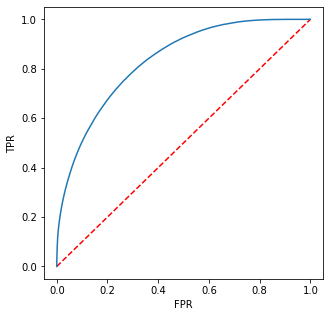

In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lr_final_model.summary.roc.select('FPR').collect(),
        lr_final_model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
preds = lr_final_model.transform(test_df)
pred_results = preds.select('label', 'pred').rdd


In [ ]:
train_df = transformed_df.sample(.3, 2022) #sampling to reduce vary large compute time
train_df = train_df.select('reduced_features', 'label', 'FL_DATE')

xgb_final_score, xgb_final_model = test_eval(train_df, test_df, final_xgb_params, 'xgb')

Starting fold 0 with parameters [('max_depth', 6), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
training started
training ended
predicting done
The AUC score for fold 0 is: 0.7597734875147854 using the parameters: [('max_depth', 6), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)]
The average score for the parameters: [('max_depth', 6), ('n_estimators', 20), ('reg_lambda', 1), ('reg_alpha', 0), ('objective', 'binary:logistic'), ('base_score', 0.5), ('learning_rate', 0.3), ('gamma', 0.05), ('scale_pos_weight', 2), ('min_child_weight', 1.5)] is 0.7597734875147854
The top AUC score for this CV run was 0.7597734875147854

In [ ]:
xgb_final_model.save('/mnt/trainedmodels/xgb_final_model')

In [ ]:
#pandas results table

results = {
  'Model': ['Baseline', 'Logistic Regression', 'XGBoost'],
  'AUC': [ 0.5, lr_final_score, xgb_final_score]
}

results_df = pd.DataFrame.from_dict(results)

results_df

Out[111]:

Model 
 AUC 
 
 
 
 
 0 
 Baseline 
 0.500000 
 
 
 1 
 Logistic Regression 
 0.806506 
 
 
 2 
 XGBoost 
 0.759773